In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [ ]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}


In [5]:
image_datasets = {
    'train': datasets.ImageFolder('Final_Data/Train', data_transforms['train']),
    'val': datasets.ImageFolder('Final_Data/Validation', data_transforms['val'])
}

In [6]:
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

In [ ]:
class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLClassifierCNN(num_classes=27).to(device)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_and_plot_hyperparameter_effects(hyperparameters, image_datasets, num_epochs=10):
    """
    Trains the model with different hyperparameter combinations and plots results.

    Args:
        hyperparameters (list of dict): List of hyperparameter dictionaries.
        image_datasets (dict): Datasets for 'train' and 'val' datasets.
        num_epochs (int): Number of epochs for each training run.

    Returns:
        pd.DataFrame: A DataFrame with hyperparameter configurations and corresponding results.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for config in hyperparameters:
        print(f"Training with hyperparameters: {config}")
        num_classes = config.get('num_classes', 27)
        learning_rate = config.get('learning_rate', 0.001)
        batch_size = config.get('batch_size', 32)
        model = ASLClassifierCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
            'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
        }
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0.0
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('-' * 20)
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)
                    batch_loss = loss.item()
                    batch_acc = torch.sum(preds == labels.data).double() / labels.size(0)
                    print(f"{phase.capitalize()} Batch {i+1}/{len(dataloaders[phase])} - Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / total_samples
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.item())
                    if epoch_acc > best_val_acc:
                        best_val_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_model.pth')
                        print(f"Saved model on {epoch+1}")
                print(f"{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        results.append({
            'config': config,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accs[-1],
            'val_acc': val_accs[-1]
        })
        plt.figure(figsize=(12, 5))
        

        ## Drawing all the curves for the training
        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss Curve ({config})")
        plt.legend()
        # Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy Curve ({config})")
        plt.legend()
        plt.tight_layout()
        plt.show()
        if len(all_preds) > 0 and len(all_labels) > 0:
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix ({config})')
            plt.show()
    results_df = pd.DataFrame(results)
    print("All configurations completed!")
    return results_df

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 64}
Epoch 1/10
--------------------
Train Batch 1/88 - Loss: 3.2994, Accuracy: 0.0000
Train Batch 2/88 - Loss: 6.2541, Accuracy: 0.0469
Train Batch 3/88 - Loss: 3.9700, Accuracy: 0.0312
Train Batch 4/88 - Loss: 3.4473, Accuracy: 0.0469
Train Batch 5/88 - Loss: 3.3021, Accuracy: 0.0000
Train Batch 6/88 - Loss: 3.2904, Accuracy: 0.0469
Train Batch 7/88 - Loss: 3.2940, Accuracy: 0.0156
Train Batch 8/88 - Loss: 3.2993, Accuracy: 0.0312
Train Batch 9/88 - Loss: 3.2882, Accuracy: 0.0469
Train Batch 10/88 - Loss: 3.2965, Accuracy: 0.0469
Train Batch 11/88 - Loss: 3.2948, Accuracy: 0.0156
Train Batch 12/88 - Loss: 3.2743, Accuracy: 0.0469
Train Batch 13/88 - Loss: 3.3016, Accuracy: 0.0156
Train Batch 14/88 - Loss: 3.3160, Accuracy: 0.0156
Train Batch 15/88 - Loss: 3.3167, Accuracy: 0.0625
Train Batch 16/88 - Loss: 3.3051, Accuracy: 0.0156
Train Batch 17/88 - Loss: 3.2890, Accuracy: 0.0469
Train Batch 18/88

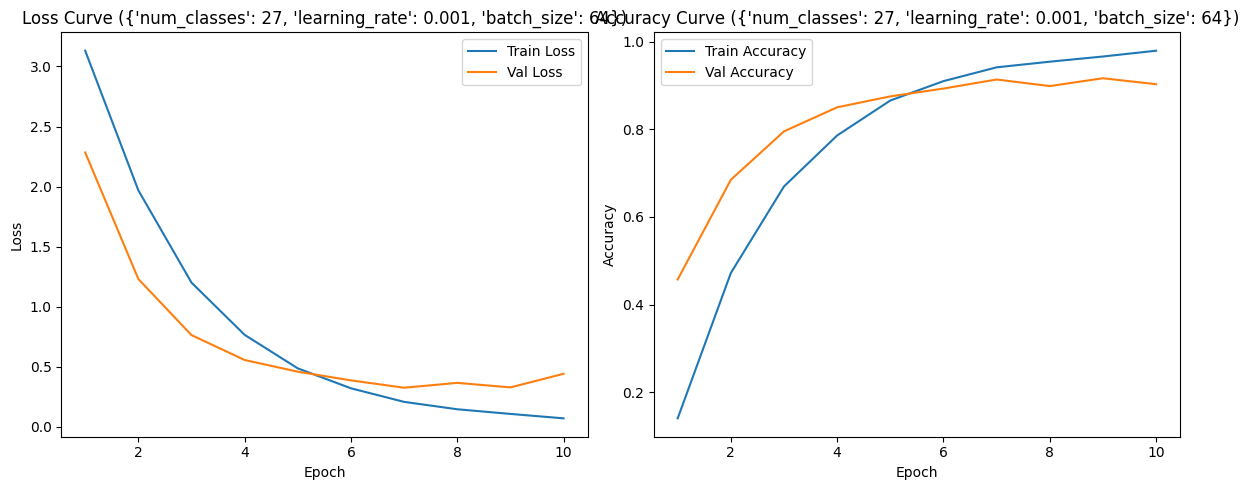

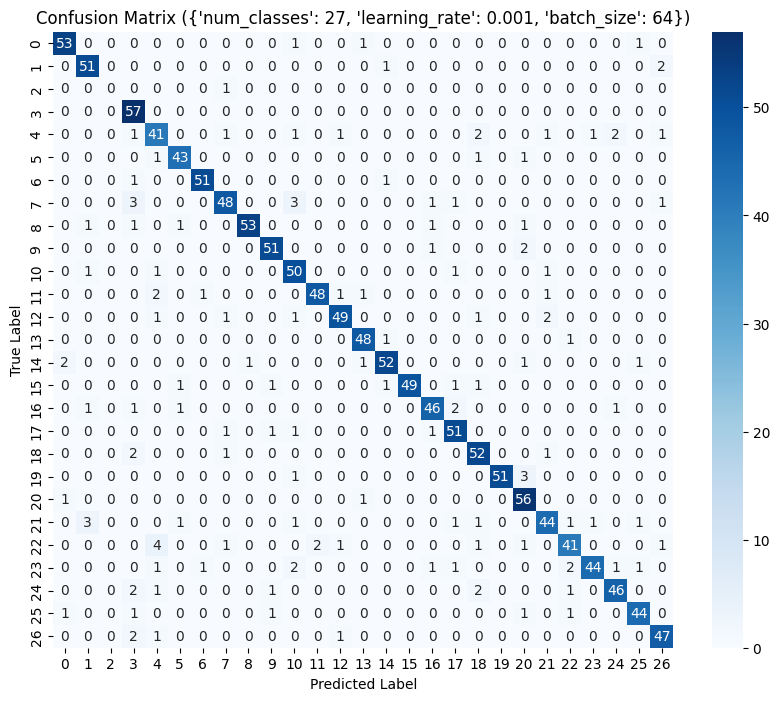

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 64}
Epoch 1/10
--------------------
Train Batch 1/88 - Loss: 3.3031, Accuracy: 0.0625
Train Batch 2/88 - Loss: 4.3830, Accuracy: 0.0312
Train Batch 3/88 - Loss: 3.6218, Accuracy: 0.0625
Train Batch 4/88 - Loss: 3.6993, Accuracy: 0.0312
Train Batch 5/88 - Loss: 3.4469, Accuracy: 0.0312
Train Batch 6/88 - Loss: 3.3687, Accuracy: 0.0000
Train Batch 7/88 - Loss: 3.2991, Accuracy: 0.0312
Train Batch 8/88 - Loss: 3.3018, Accuracy: 0.0156
Train Batch 9/88 - Loss: 3.2787, Accuracy: 0.0312
Train Batch 10/88 - Loss: 3.2799, Accuracy: 0.0469
Train Batch 11/88 - Loss: 3.2977, Accuracy: 0.0469
Train Batch 12/88 - Loss: 3.2907, Accuracy: 0.0156
Train Batch 13/88 - Loss: 3.2880, Accuracy: 0.0312
Train Batch 14/88 - Loss: 3.2925, Accuracy: 0.0156
Train Batch 15/88 - Loss: 3.2864, Accuracy: 0.0469
Train Batch 16/88 - Loss: 3.2775, Accuracy: 0.0469
Train Batch 17/88 - Loss: 3.2962, Accuracy: 0.0469
Train Batch 18/8

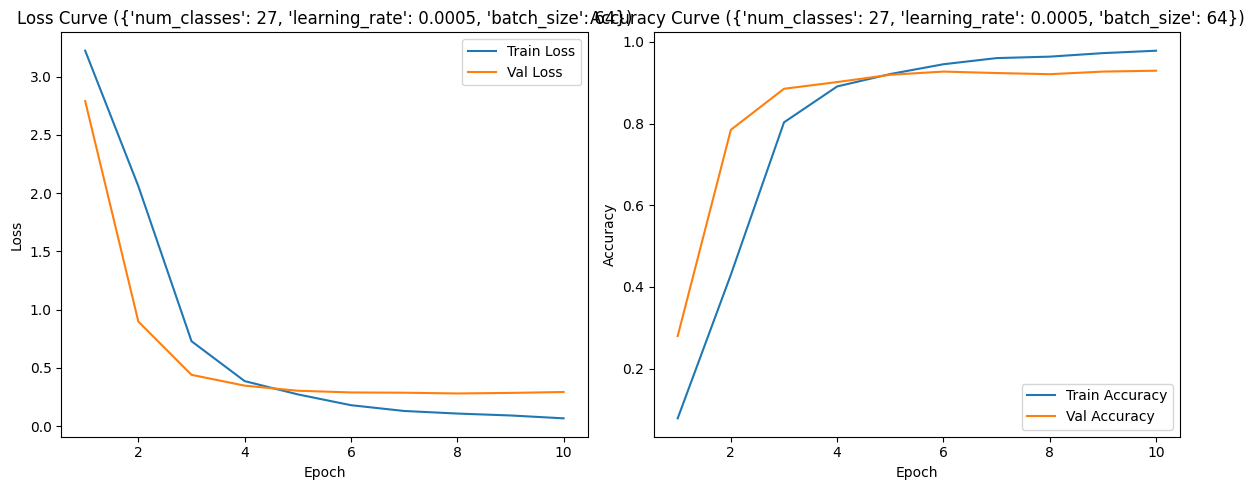

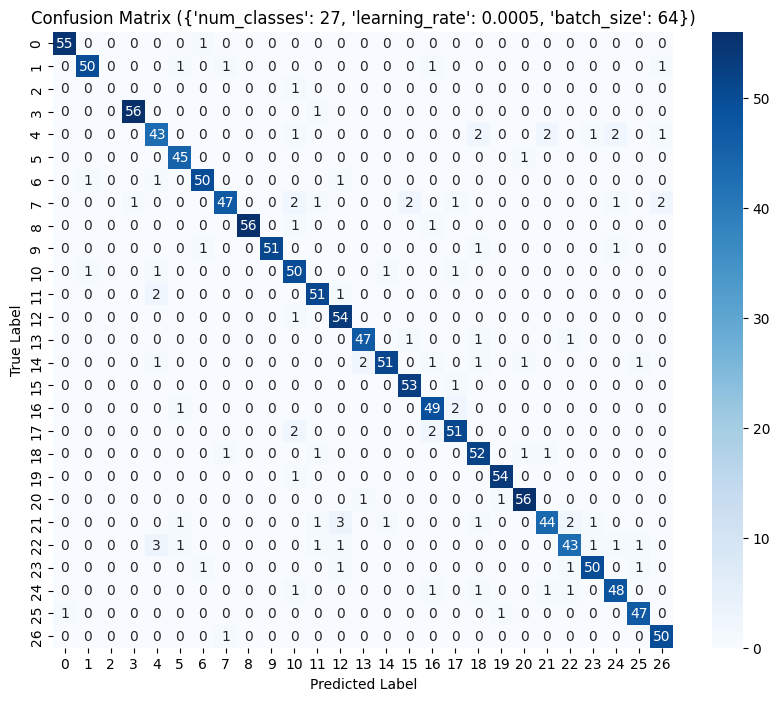

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.005, 'batch_size': 64}
Epoch 1/10
--------------------
Train Batch 1/88 - Loss: 3.3020, Accuracy: 0.0000
Train Batch 2/88 - Loss: 38.2399, Accuracy: 0.0156
Train Batch 3/88 - Loss: 7.3240, Accuracy: 0.0312
Train Batch 4/88 - Loss: 3.4067, Accuracy: 0.0000
Train Batch 5/88 - Loss: 3.2576, Accuracy: 0.0938
Train Batch 6/88 - Loss: 3.3097, Accuracy: 0.0312
Train Batch 7/88 - Loss: 3.3174, Accuracy: 0.0625
Train Batch 8/88 - Loss: 3.2882, Accuracy: 0.0469
Train Batch 9/88 - Loss: 3.2880, Accuracy: 0.0156
Train Batch 10/88 - Loss: 3.2628, Accuracy: 0.0469
Train Batch 11/88 - Loss: 3.3440, Accuracy: 0.0469
Train Batch 12/88 - Loss: 3.3261, Accuracy: 0.1406
Train Batch 13/88 - Loss: 3.2746, Accuracy: 0.0625
Train Batch 14/88 - Loss: 3.2823, Accuracy: 0.0312
Train Batch 15/88 - Loss: 3.2999, Accuracy: 0.0625
Train Batch 16/88 - Loss: 3.2931, Accuracy: 0.0312
Train Batch 17/88 - Loss: 3.2811, Accuracy: 0.0312
Train Batch 18/8

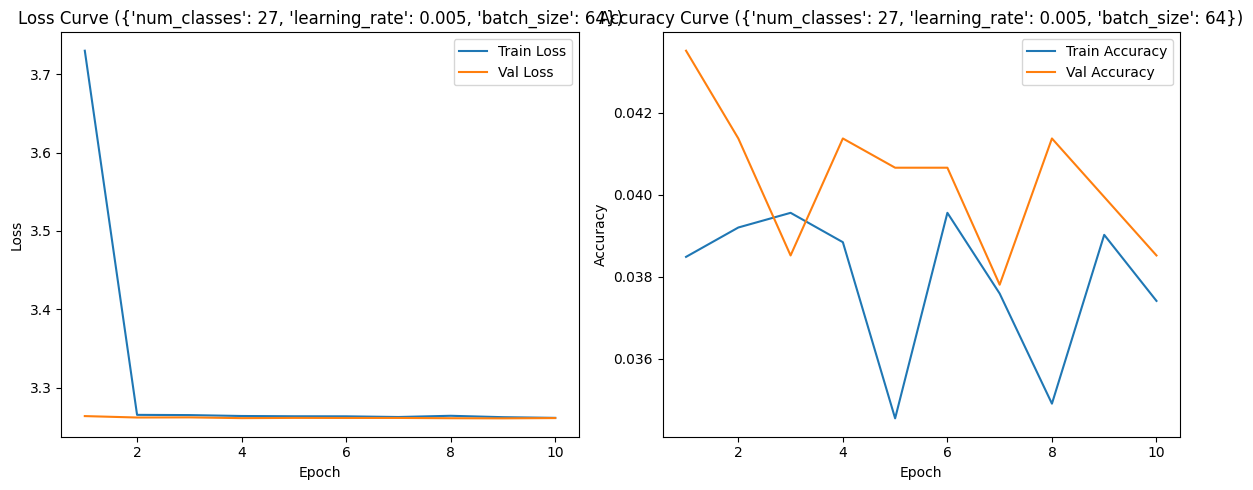

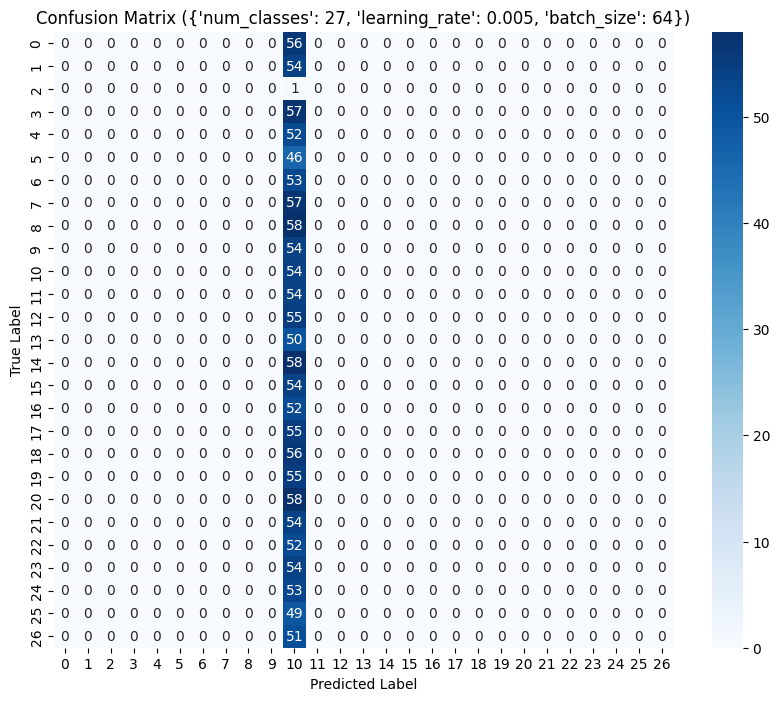

All configurations completed!
                                              config  train_loss  val_loss  \
0  {'num_classes': 27, 'learning_rate': 0.001, 'b...    0.071016  0.441800   
1  {'num_classes': 27, 'learning_rate': 0.0005, '...    0.067164  0.293315   
2  {'num_classes': 27, 'learning_rate': 0.005, 'b...    3.261586  3.261317   

   train_acc   val_acc  
0   0.979417  0.902996  
1   0.978343  0.929387  
2   0.037408  0.038516  


In [9]:
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 64},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 64},
    {'num_classes': 27, 'learning_rate': 0.005, 'batch_size': 64},
]

results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=10)

print(results_df)

we see that the learning rate should be between 0.001 and 0.0005. Now we will experiment with different batch sizes, with learning rate 0.0005

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
Epoch 1/10
--------------------
Train Batch 1/44 - Loss: 3.3008, Accuracy: 0.0234
Train Batch 2/44 - Loss: 3.7135, Accuracy: 0.0312
Train Batch 3/44 - Loss: 3.3735, Accuracy: 0.0234
Train Batch 4/44 - Loss: 3.3660, Accuracy: 0.0469
Train Batch 5/44 - Loss: 3.3366, Accuracy: 0.0000
Train Batch 6/44 - Loss: 3.2764, Accuracy: 0.0234
Train Batch 7/44 - Loss: 3.2788, Accuracy: 0.0391
Train Batch 8/44 - Loss: 3.2733, Accuracy: 0.0703
Train Batch 9/44 - Loss: 3.2843, Accuracy: 0.0234
Train Batch 10/44 - Loss: 3.2849, Accuracy: 0.0234
Train Batch 11/44 - Loss: 3.2601, Accuracy: 0.0391
Train Batch 12/44 - Loss: 3.2644, Accuracy: 0.0781
Train Batch 13/44 - Loss: 3.2866, Accuracy: 0.0312
Train Batch 14/44 - Loss: 3.2553, Accuracy: 0.0391
Train Batch 15/44 - Loss: 3.2574, Accuracy: 0.0781
Train Batch 16/44 - Loss: 3.2815, Accuracy: 0.0547
Train Batch 17/44 - Loss: 3.2426, Accuracy: 0.0547
Train Batch 18/

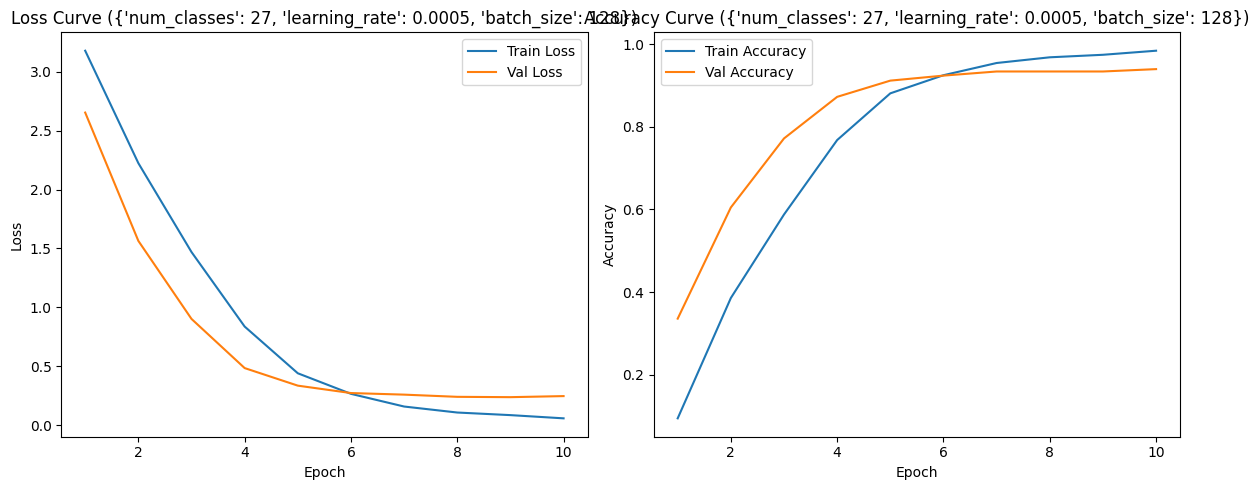

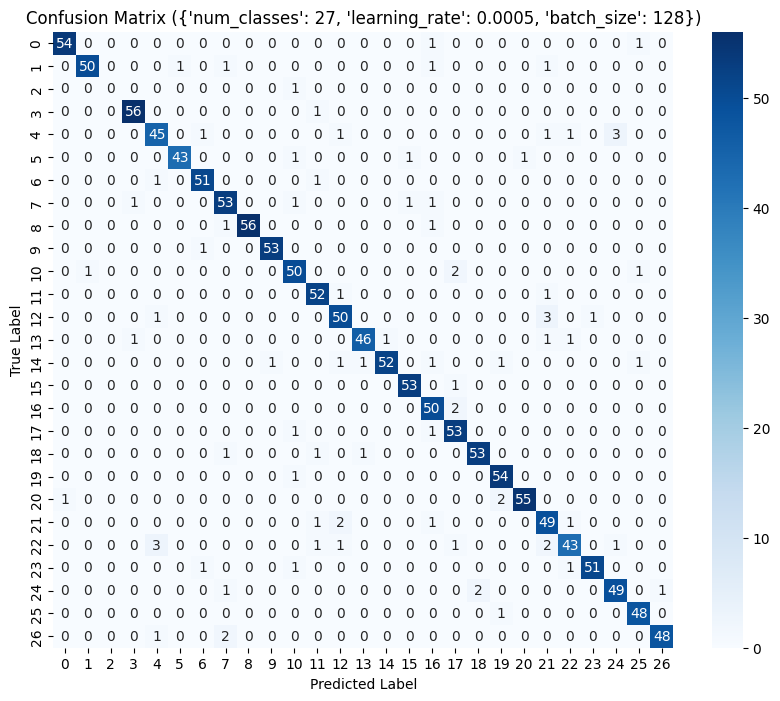

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 256}
Epoch 1/10
--------------------
Train Batch 1/22 - Loss: 3.2965, Accuracy: 0.0078
Train Batch 2/22 - Loss: 3.7073, Accuracy: 0.0352
Train Batch 3/22 - Loss: 3.4227, Accuracy: 0.0508
Train Batch 4/22 - Loss: 3.3734, Accuracy: 0.0234
Train Batch 5/22 - Loss: 3.3049, Accuracy: 0.0352
Train Batch 6/22 - Loss: 3.2861, Accuracy: 0.0547
Train Batch 7/22 - Loss: 3.2897, Accuracy: 0.0352
Train Batch 8/22 - Loss: 3.2860, Accuracy: 0.0508
Train Batch 9/22 - Loss: 3.2823, Accuracy: 0.0625
Train Batch 10/22 - Loss: 3.2800, Accuracy: 0.0547
Train Batch 11/22 - Loss: 3.2776, Accuracy: 0.0469
Train Batch 12/22 - Loss: 3.2776, Accuracy: 0.0625
Train Batch 13/22 - Loss: 3.2451, Accuracy: 0.0820
Train Batch 14/22 - Loss: 3.2456, Accuracy: 0.0547
Train Batch 15/22 - Loss: 3.2429, Accuracy: 0.0625
Train Batch 16/22 - Loss: 3.2195, Accuracy: 0.0820
Train Batch 17/22 - Loss: 3.2006, Accuracy: 0.0781
Train Batch 18/

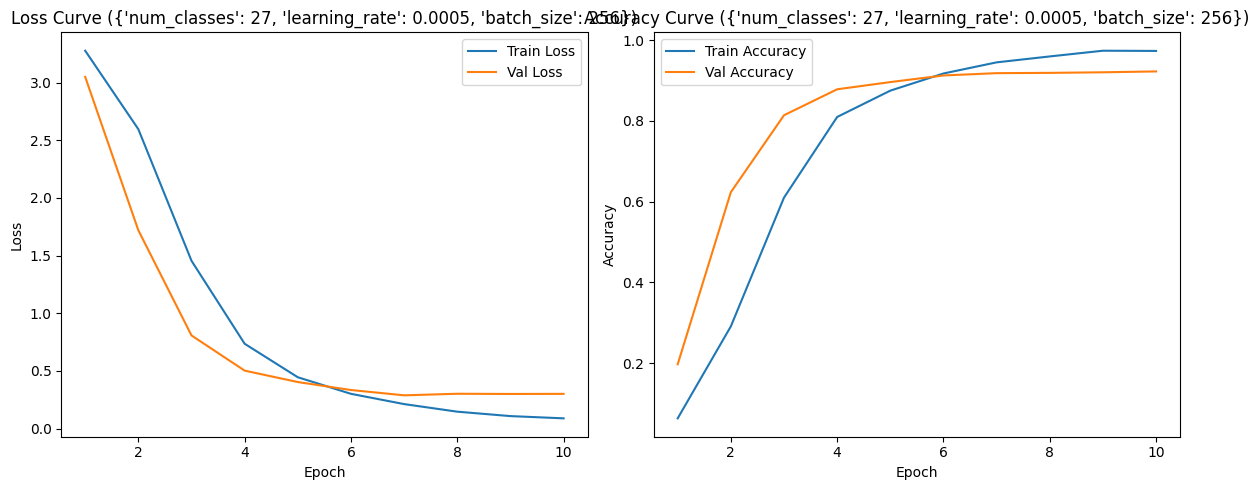

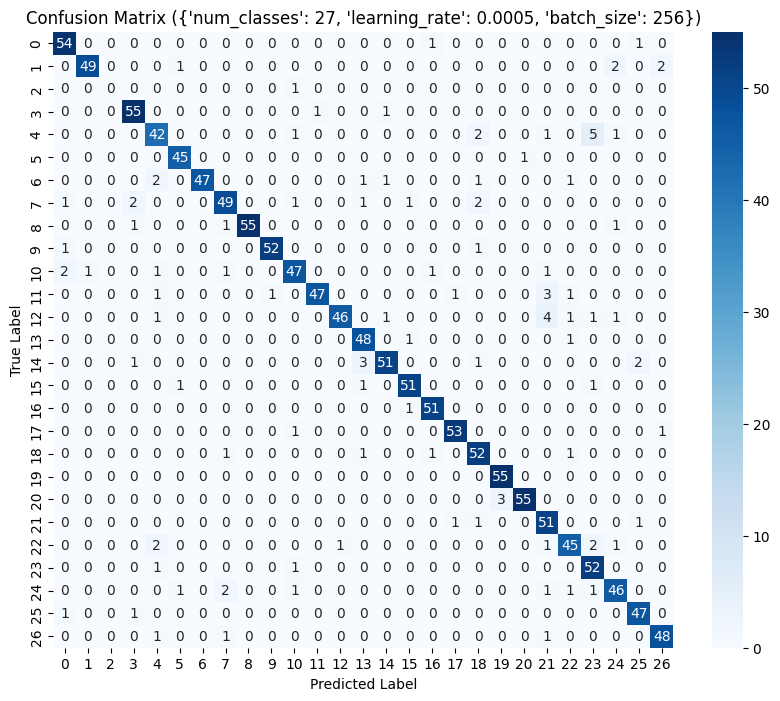

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 512}
Epoch 1/10
--------------------
Train Batch 1/11 - Loss: 3.2956, Accuracy: 0.0312
Train Batch 2/11 - Loss: 3.4887, Accuracy: 0.0273
Train Batch 3/11 - Loss: 3.3655, Accuracy: 0.0449
Train Batch 4/11 - Loss: 3.2856, Accuracy: 0.0430
Train Batch 5/11 - Loss: 3.2917, Accuracy: 0.0410
Train Batch 6/11 - Loss: 3.2830, Accuracy: 0.0449
Train Batch 7/11 - Loss: 3.2697, Accuracy: 0.0508
Train Batch 8/11 - Loss: 3.2707, Accuracy: 0.0645
Train Batch 9/11 - Loss: 3.2587, Accuracy: 0.0586
Train Batch 10/11 - Loss: 3.2516, Accuracy: 0.0762
Train Batch 11/11 - Loss: 3.2513, Accuracy: 0.0600
Train Epoch Loss: 3.3015 Acc: 0.0492
Val Batch 1/3 - Loss: 3.1513, Accuracy: 0.2246
Val Batch 2/3 - Loss: 3.2593, Accuracy: 0.0137
Val Batch 3/3 - Loss: 3.2586, Accuracy: 0.0370
Saved model on 1
Val Epoch Loss: 3.2196 Acc: 0.0970
Epoch 2/10
--------------------
Train Batch 1/11 - Loss: 3.2240, Accuracy: 0.0781
Train Bat

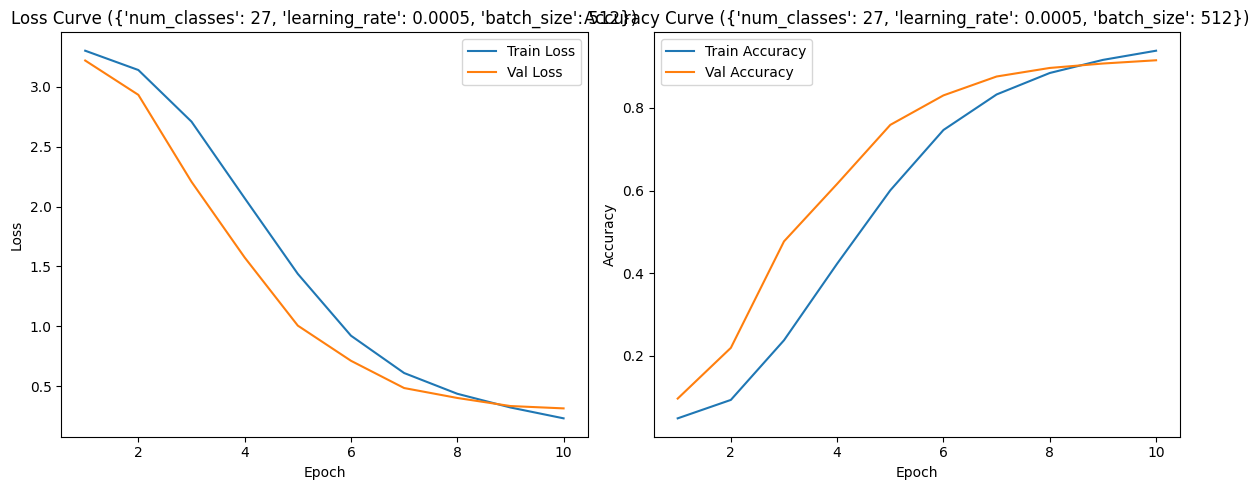

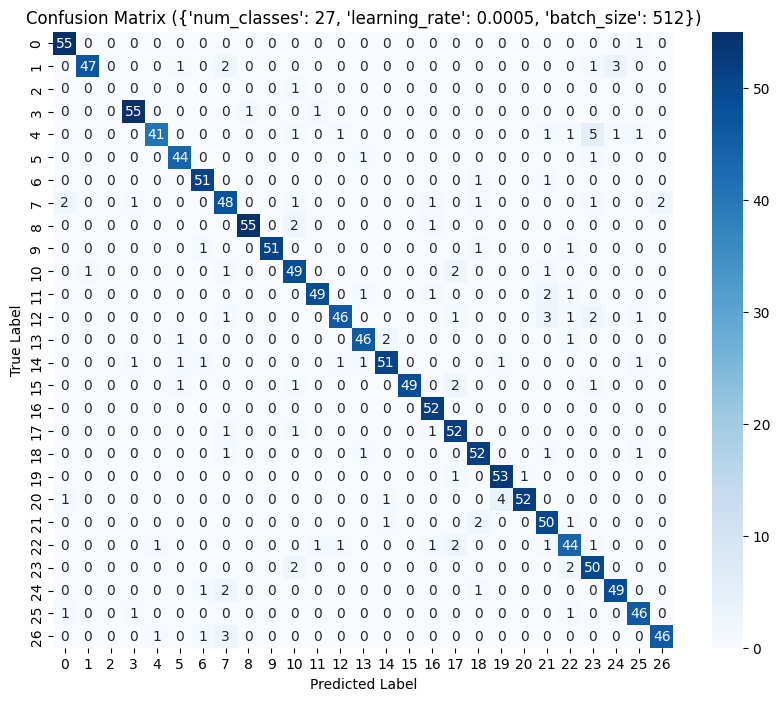

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 1024}
Epoch 1/10
--------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 19.52 GiB is allocated by PyTorch, and 1014.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 256},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 512},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 1024}
]

results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=10)

print(results_df)

Training the best hyperparameters found

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
Epoch 1/4
--------------------
Train Batch 1/44 - Loss: 3.2949, Accuracy: 0.0234
Train Batch 2/44 - Loss: 3.8645, Accuracy: 0.0312
Train Batch 3/44 - Loss: 3.6650, Accuracy: 0.0312
Train Batch 4/44 - Loss: 3.5323, Accuracy: 0.0312
Train Batch 5/44 - Loss: 3.3166, Accuracy: 0.0234
Train Batch 6/44 - Loss: 3.3147, Accuracy: 0.0703
Train Batch 7/44 - Loss: 3.2913, Accuracy: 0.0234
Train Batch 8/44 - Loss: 3.2965, Accuracy: 0.0234
Train Batch 9/44 - Loss: 3.2935, Accuracy: 0.0078
Train Batch 10/44 - Loss: 3.2896, Accuracy: 0.0391
Train Batch 11/44 - Loss: 3.2963, Accuracy: 0.0547
Train Batch 12/44 - Loss: 3.2894, Accuracy: 0.0547
Train Batch 13/44 - Loss: 3.2997, Accuracy: 0.0312
Train Batch 14/44 - Loss: 3.2824, Accuracy: 0.0391
Train Batch 15/44 - Loss: 3.2940, Accuracy: 0.0391
Train Batch 16/44 - Loss: 3.2659, Accuracy: 0.0625
Train Batch 17/44 - Loss: 3.2767, Accuracy: 0.0703
Train Batch 18/4

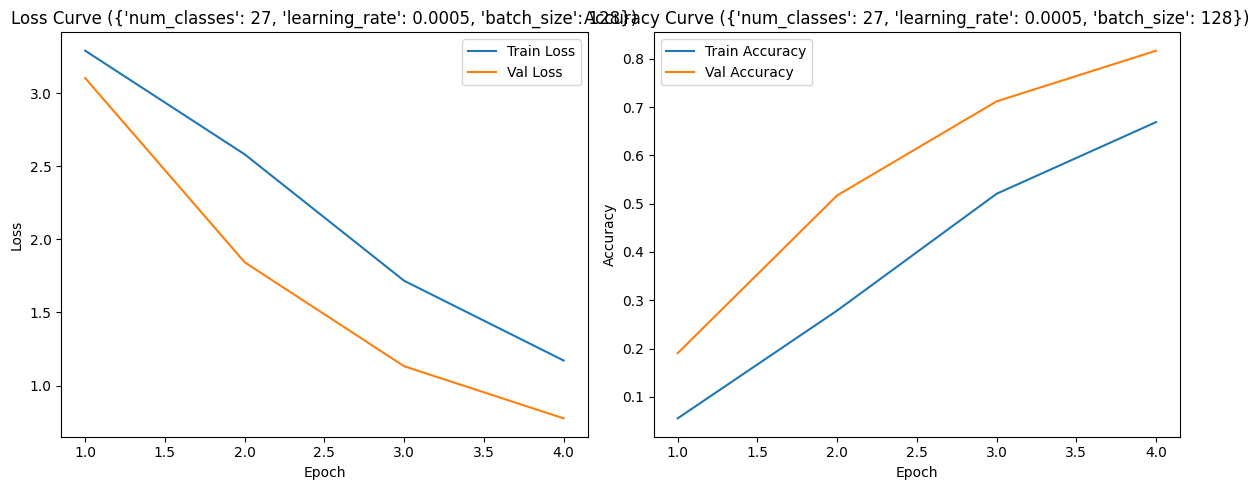

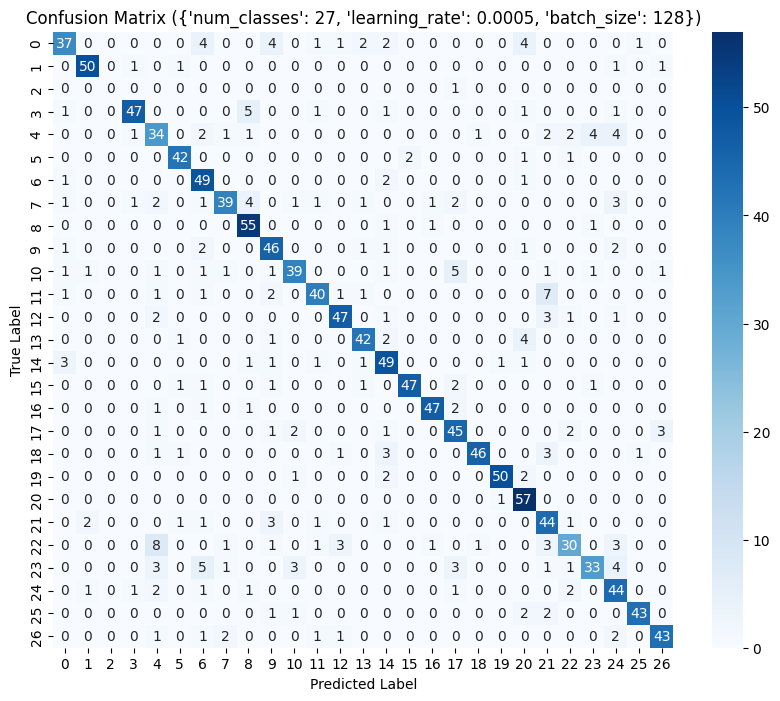

All configurations completed!
                                              config  train_loss  val_loss  \
0  {'num_classes': 27, 'learning_rate': 0.0005, '...    1.171642  0.776174   

   train_acc  val_acc  
0   0.668874  0.81669  


In [22]:
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 128}
]

results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=4)

print(results_df)